# SENTIMENT ANALYSIS AND OPINION MINING PROJECT
## PUBLIC OPINION ON NEWS

https://island.ricerca.di.unimi.it/~alfio/shared/textsent/2020-21/projects.html

The New York Times Comments dataset (https://www.kaggle.com/aashita/nyt-comments?select=CommentsApril2017.csv) contains articles published on the New York Times and the comments they received from readers. <br>
The task of the project is to analyze, using the variables *editorsSelection*, *recommendations*, and *replyCount* as targets, the rate of success of a comment. This rate of success should be intepreted as a measure of how much controversial was the commented article. On this base, the project aims at studing which topics (indicated by the features sectionName and/or newDesk) were mostly controversial. Optionally, the project could also determine if a comment opinion is against or if favor of the article.

# 3. UNSUPERVISED SENTIMENT POLARITY LABELLING OF COMMENTS 

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
import seaborn as sns
import matplotlib.pylab as plt
import pickle
from tqdm.auto import tqdm
import time
import itertools
import functools
import operator
import time
from collections import defaultdict
import os
#from google.colab import drive, files

from glob import glob
import os
import json
import numpy as np
import matplotlib.image as img
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import imread

import torch
import torch.nn.functional as F
#import torchvision
#import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

# VARIANT: UNSUPERVISED LABELLING
New labels are created in an unsupervised way, so by using a lexicon-based method. The comments will be classified as positive, negative or neutral. <br>
The overall sentiments will be used to assess the general mood of comments which led to greater engagement, in order to see if these might potentially be good predictors. A final classification on how engaging are the comments is obtained by dividing the comments into 3 types:
- moderate engagement: at least one label = 1
- medium engagement: at least two labels = 1
- high engagement: all three labels = 1
Then we see if the average polarity and strenght of these comments is a good predictor of the different engagement levels.


In [7]:
X,y = Data_Load('dataset_cleansed_version.csv', network_type='ENC_CNN').load()

In [8]:
pip install textblob

Note: you may need to restart the kernel to use updated packages.


### 1) TEXTBLOB

In [50]:
from textblob import TextBlob

#The sentiment property returns a namedtuple of the form Sentiment(polarity, subjectivity). 
#The polarity score is a float within the range [-1.0, 1.0]. The subjectivity is a float within the range [0.0, 1.0]
# where 0.0 is very objective and 1.0 is very subjective.

# positive sentences: 0.2 : 1
# neutral sentence: -0.2 : 0.2
# negative sentence: -1 : -0.2

def get_sentiment_absolute(x):
  
  comment = TextBlob(str(x))
  polarity = comment.sentiment.polarity
  return 1 if polarity >=0.01 else -1 if polarity <=-0.01 else 0

def get_sentiment(x):
  
  comment = TextBlob(str(x))
  polarity = comment.sentiment.polarity
  return polarity

def get_sentiment_subjectivity(x):
    comment = TextBlob(str(x))
    polarity = comment.sentiment.polarity
    subj = comment.sentiment.subjectivity
    return polarity*subj
  #return polarity #1 if polarity >=0.01 else -1 if polarity <=-0.01 else 0

In [11]:
X = X[['commentBody','editorsSelection_TARGET','recommendations_TARGET','replyCount_TARGET']]
X = pd.concat([X,y], axis=1)

In [12]:
X['sentiment'] = X['commentBody'].apply(get_sentiment)
X['sentiment_absolute'] = X['commentBody'].apply(get_sentiment_absolute)
X['sentiment_subjectivity'] = X['commentBody'].apply(get_sentiment_subjectivity)

# apply robust standardisation ?

In [51]:
X['sentiment_subjectivity_2'] = X['commentBody'].apply(get_sentiment_subjectivity)

In [14]:
X['Summary_TARGET_multiclass'] = X[['editorsSelection_TARGET',
                         'recommendations_TARGET','replyCount_TARGET']].sum(axis=1)

In [16]:
X['Summary_TARGET_binary'] = X[['editorsSelection_TARGET',
                         'recommendations_TARGET','replyCount_TARGET']].sum(axis=1).apply(lambda x: 1 if x>=1 else 0)

In [32]:
X.groupby('Summary_TARGET_multiclass').agg([np.mean,np.median,np.std])[['sentiment','sentiment_absolute','sentiment_subjectivity']] # or describe(). then also try boxplot

sentiment                     sentiment_absolute  \
                               mean    median       std               mean   
Summary_TARGET_multiclass                                                    
0                          0.059314  0.000000  0.246944           0.224924   
1                          0.056813  0.018182  0.246643           0.229629   
2                          0.055200  0.034467  0.227081           0.255422   
3                          0.056621  0.050000  0.196271           0.293221   

                                           sentiment_subjectivity            \
                          median       std                   mean    median   
Summary_TARGET_multiclass                                                     
0                              0  0.832206               0.220683  0.485714   
1                              1  0.860024               0.203494  0.479167   
2                              1  0.875651               0.200298  0.471212   
3                              1  0.902152               0.204477  0.473333   

                                     
                                std  
Summary_TARGET_multiclass            
0                          0.769652  
1                          0.761497  
2                          0.714621  
3                          0.655247

In [33]:
X.groupby('Summary_TARGET_binary').agg([np.mean,np.median,np.std])[['sentiment','sentiment_absolute','sentiment_subjectivity']] # or describe(). then also try boxplot

sentiment                  sentiment_absolute         \
                           mean median       std               mean median   
Summary_TARGET_binary                                                        
0                      0.059314  0.000  0.246944           0.224924      0   
1                      0.056418  0.025  0.240967           0.237368      1   

                                sentiment_subjectivity                      
                            std                   mean    median       std  
Summary_TARGET_binary                                                       
0                      0.832206               0.220683  0.485714  0.769652  
1                      0.864955               0.202717  0.476548  0.747334

In [3]:
X = pd.read_csv('dataset_sentiment_comments.csv')

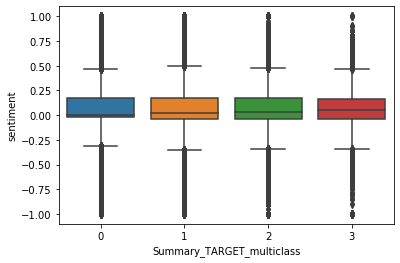

In [43]:
ax = sns.boxplot(x="Summary_TARGET_multiclass", y="sentiment", data=X) 

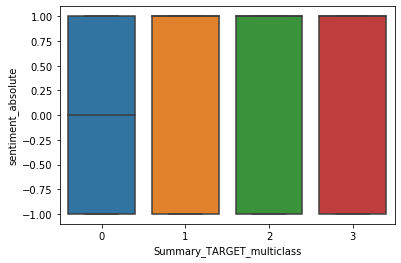

In [44]:
ax = sns.boxplot(x="Summary_TARGET_multiclass", y="sentiment_absolute", data=X) 

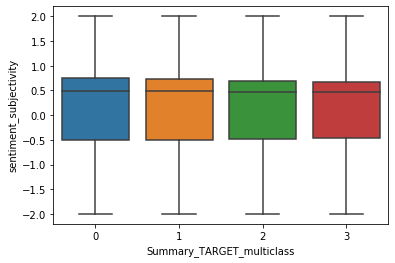

In [45]:
ax = sns.boxplot(x="Summary_TARGET_multiclass", y="sentiment_subjectivity", data=X) 

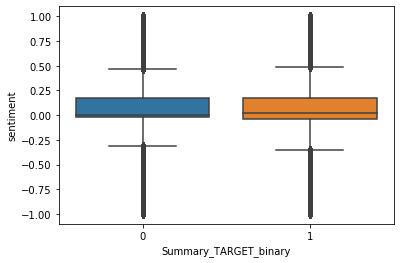

In [46]:
ax = sns.boxplot(x="Summary_TARGET_binary", y="sentiment", data=X) 

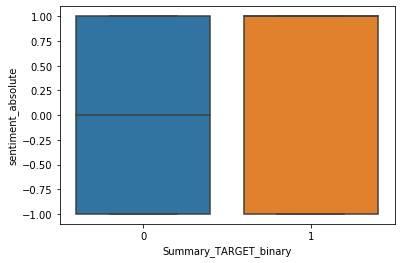

In [47]:
ax = sns.boxplot(x="Summary_TARGET_binary", y="sentiment_absolute", data=X) 

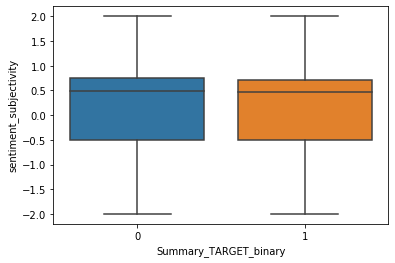

In [48]:
ax = sns.boxplot(x="Summary_TARGET_binary", y="sentiment_subjectivity", data=X) 

### 2) VADER

In [5]:
X2 = pd.read_csv('PROJECT_SA/dataset_sentiment_comments.csv')
X2 = X2[["Summary_TARGET_binary", 'Summary_TARGET_multiclass','commentBody']]

In [32]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

def get_sentiment_compound(x):
    polarity = sid.polarity_scores(str(x))
    return polarity['compound']

def get_sentiment_absolute(x):
    polarity = sid.polarity_scores(str(x))
    del polarity['compound']
    max_pol = max(polarity.items(), key=operator.itemgetter(1))[0]
    return 1 if max_pol == 'pos' else -1 if max_pol == 'neg' else 0

def get_sentiment(x):
    polarity = sid.polarity_scores(str(x))
    del polarity['compound']
    max_pol = max(polarity.items(), key=operator.itemgetter(1))
    return max_pol[1] if max_pol[0] == 'pos' else - max_pol[1] if max_pol[0] == 'neg' else 0    
# we can also return 0 if max is neutral, or return the number itself if pos 
#is max or - the number if max is neg

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/Niki/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [33]:
X2['sentiment'] = X2['commentBody'].apply(get_sentiment)
X2['sentiment_absolute'] = X2['commentBody'].apply(get_sentiment_absolute)
X2['sentiment_compound'] = X2['commentBody'].apply(get_sentiment_compound)

In [38]:
X2.groupby('Summary_TARGET_binary').agg([np.mean,np.median,np.std])[['sentiment','sentiment_absolute','sentiment_compound']] # or describe(). then also try boxplot

sentiment                  sentiment_absolute         \
                           mean median       std               mean median   
Summary_TARGET_binary                                                        
0                      0.007184    0.0  0.228156           0.007181      0   
1                      0.001348    0.0  0.205792           0.000168      0   

                                sentiment_compound                   
                            std               mean median       std  
Summary_TARGET_binary                                                
0                      0.377750           0.055725    0.0  0.549911  
1                      0.355226           0.050024    0.0  0.594931

In [39]:
X2.groupby('Summary_TARGET_multiclass').agg([np.mean,np.median,np.std])[['sentiment','sentiment_absolute','sentiment_compound']] # or describe(). then also try boxplot

sentiment                  sentiment_absolute  \
                               mean median       std               mean   
Summary_TARGET_multiclass                                                 
0                          0.007184    0.0  0.228156           0.007181   
1                          0.002583    0.0  0.214762           0.001879   
2                         -0.002325    0.0  0.181697          -0.005043   
3                          0.000636    0.0  0.143223           0.000434   

                                           sentiment_compound                   
                          median       std               mean median       std  
Summary_TARGET_multiclass                                                       
0                              0  0.377750           0.055725  0.000  0.549911  
1                              0  0.367223           0.049138  0.000  0.585227  
2                              0  0.323919           0.050420  0.000  0.615905  
3                              0  0.272185           0.073701  0.128  0.670562

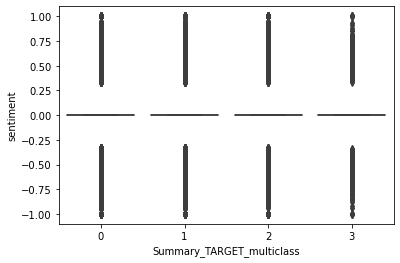

In [40]:
ax = sns.boxplot(x="Summary_TARGET_multiclass", y="sentiment", data=X2) 

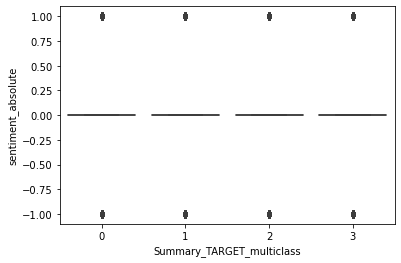

In [41]:
ax = sns.boxplot(x="Summary_TARGET_multiclass", y="sentiment_absolute", data=X2) 

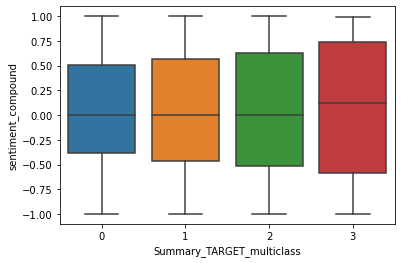

In [42]:
ax = sns.boxplot(x="Summary_TARGET_multiclass", y="sentiment_compound", data=X2) 

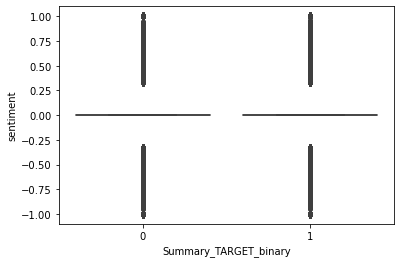

In [43]:
ax = sns.boxplot(x="Summary_TARGET_binary", y="sentiment", data=X2) 

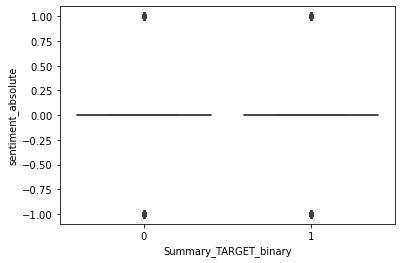

In [44]:
ax = sns.boxplot(x="Summary_TARGET_binary", y="sentiment_absolute", data=X2) 

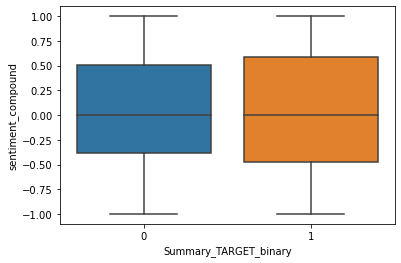

In [46]:
ax = sns.boxplot(x="Summary_TARGET_binary", y="sentiment_compound", data=X2) 

In [35]:
X2.to_csv('PROJECT_SA/dataset_sentiment_comments_2')

# MOST CONTROVERSIAL TOPICS

In [7]:
X = pd.read_csv('PROJECT_SA/dataset_cleansed_version.csv')
X = X[['editorsSelection_TARGET','recommendations_TARGET','replyCount_TARGET','sectionName_x','newDesk_x']]

In [80]:
X['Summary_TARGET_multiclass'] = X[['editorsSelection_TARGET',
                         'recommendations_TARGET','replyCount_TARGET']].sum(axis=1)

X['Summary_TARGET_binary'] = X[['editorsSelection_TARGET',
                         'recommendations_TARGET','replyCount_TARGET']].sum(axis=1).apply(lambda x: 1 if x>=1 else 0)

First, we retrieve the percentage of controversial and non-controversial comments for each topic

In [167]:
freq_newDesk_X = pd.DataFrame(X.groupby(['newDesk_x','Summary_TARGET_binary']).count().iloc[:,0])
freq_newDesk_X.columns = ['count']

freq_newDesk_X = freq_newDesk_X / freq_newDesk_X.groupby('newDesk_x').sum()
freq_newDesk_X.reset_index(level=[0,1], inplace=True)

In [168]:
freq_newDesk_X

,newDesk_x,Summary_TARGET_binary,count
0,Arts&Leisure,0,0.378449
1,Arts&Leisure,1,0.621551
2,Automobiles,0,1.000000
3,BookReview,0,0.453240
4,BookReview,1,0.546760
...,...,...,...
82,Washington,1,0.580527
83,Weekend,0,0.428417
84,Weekend,1,0.571583
85,Well,0,0.378799


In [169]:
freq_sectionName_X = pd.DataFrame(X.groupby(['sectionName_x','Summary_TARGET_binary']).count().iloc[:,0])
freq_sectionName_X.columns = ['count']

freq_sectionName_X = freq_sectionName_X / freq_sectionName_X.groupby('sectionName_x').sum()
freq_sectionName_X.reset_index(level=[0,1], inplace=True)

In [170]:
freq_sectionName_X

,sectionName_x,Summary_TARGET_binary,count
0,401(k)'s and Similar Plans,0,0.494624
1,401(k)'s and Similar Plans,1,0.505376
2,Africa,0,0.411280
3,Africa,1,0.588720
4,Americas,0,0.375241
...,...,...,...
115,Unknown,1,0.526083
116,Weddings,0,0.210526
117,Weddings,1,0.789474
118,"Wine, Beer & Cocktails",0,0.580908


In order to make it more readable, only the topics where at least 60% of the comments were controversial are shown

In [171]:
controversial_topics = freq_newDesk_X['newDesk_x'][(freq_newDesk_X['Summary_TARGET_binary']==1) & (freq_newDesk_X['count']>=0.6)]
freq_newDesk_X = freq_newDesk_X[freq_newDesk_X['newDesk_x'].isin(list(controversial_topics))]

In [172]:
ascending_freq_newDesk = freq_newDesk_X[freq_newDesk_X['Summary_TARGET_binary']==1].sort_values(by='count', ascending=False)['newDesk_x']

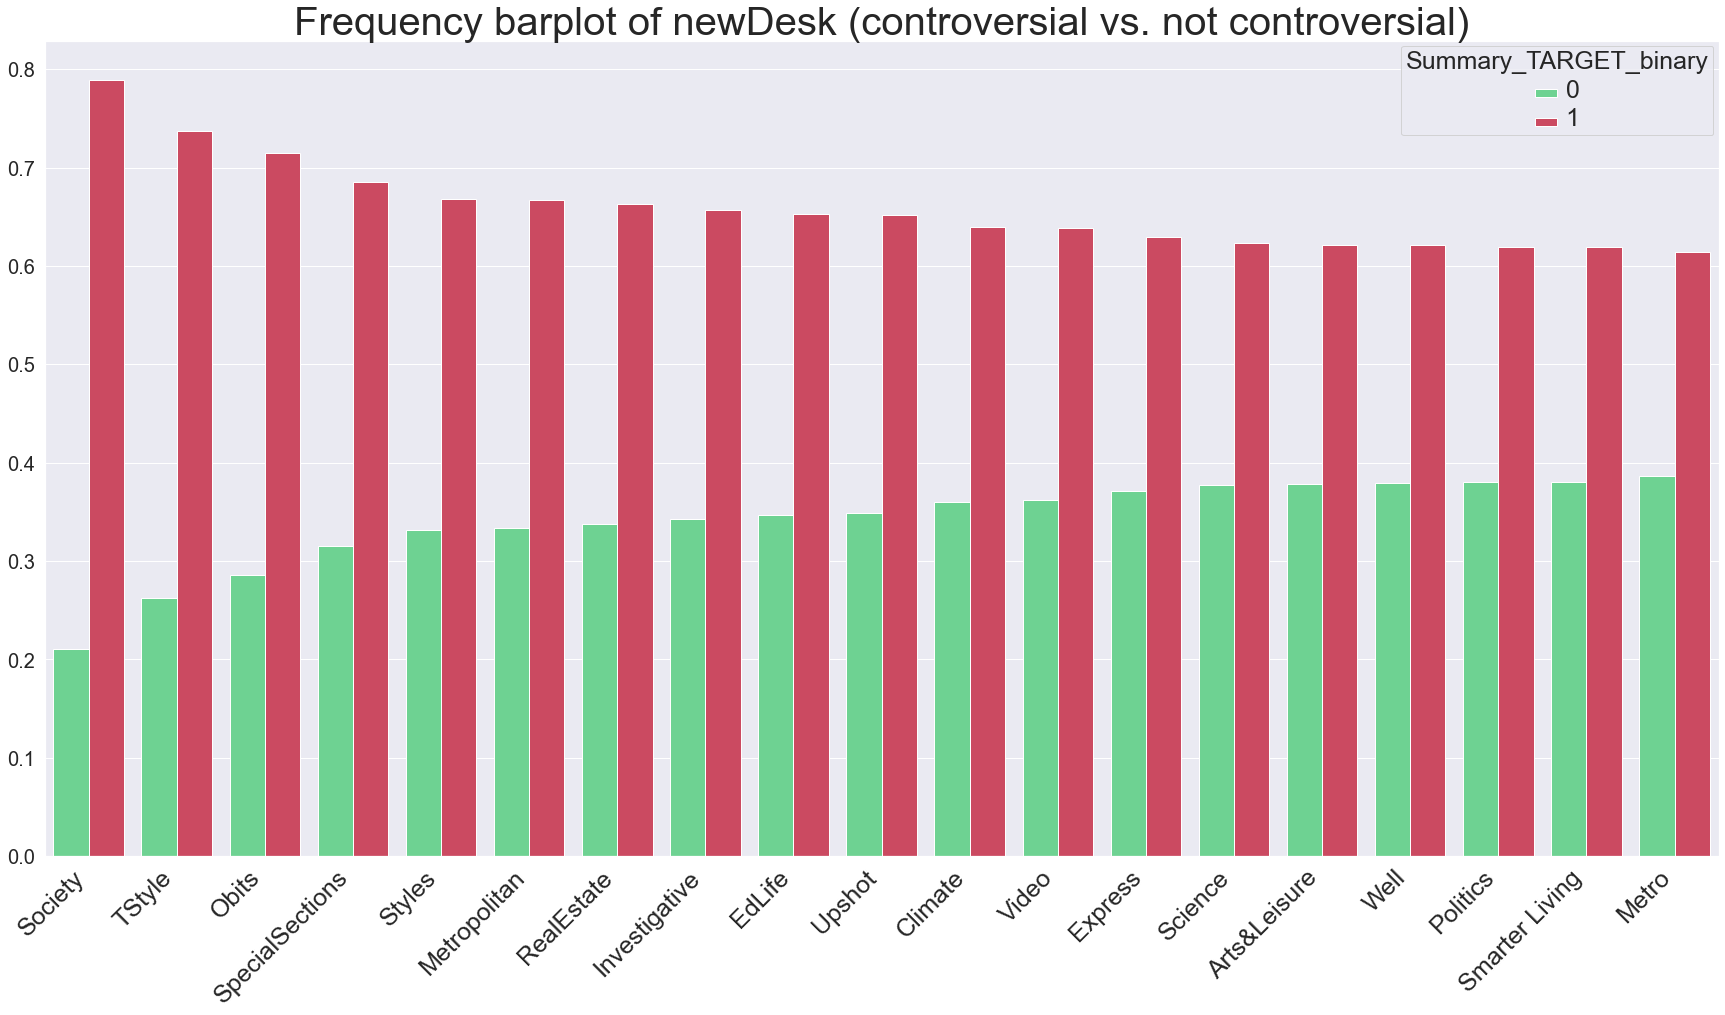

In [142]:
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(30,15)})
ax = sns.barplot(x='newDesk_x',y='count',hue='Summary_TARGET_binary', data=freq_newDesk_X, 
                 palette=["#5de38d", "#e03453"], order=ascending_freq_newDesk)
ax.set_title('Frequency barplot of newDesk (controversial vs. not controversial)',fontsize=40)

ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=25,rotation=45, horizontalalignment='right')
plt.setp(ax.get_legend().get_texts(), fontsize='25')
plt.setp(ax.get_legend().get_title(),fontsize=25)
ax.tick_params(axis="y", labelsize=20)

In [173]:
controversial_topics = freq_sectionName_X['sectionName_x'][(freq_sectionName_X['Summary_TARGET_binary']==1) & (freq_sectionName_X['count']>=0.6)]
freq_sectionName_X = freq_sectionName_X[freq_sectionName_X['sectionName_x'].isin(list(controversial_topics))]

In [174]:
ascending_freq_sectionName = freq_sectionName_X[freq_sectionName_X['Summary_TARGET_binary']==1].sort_values(by='count', ascending=False)['sectionName_x']

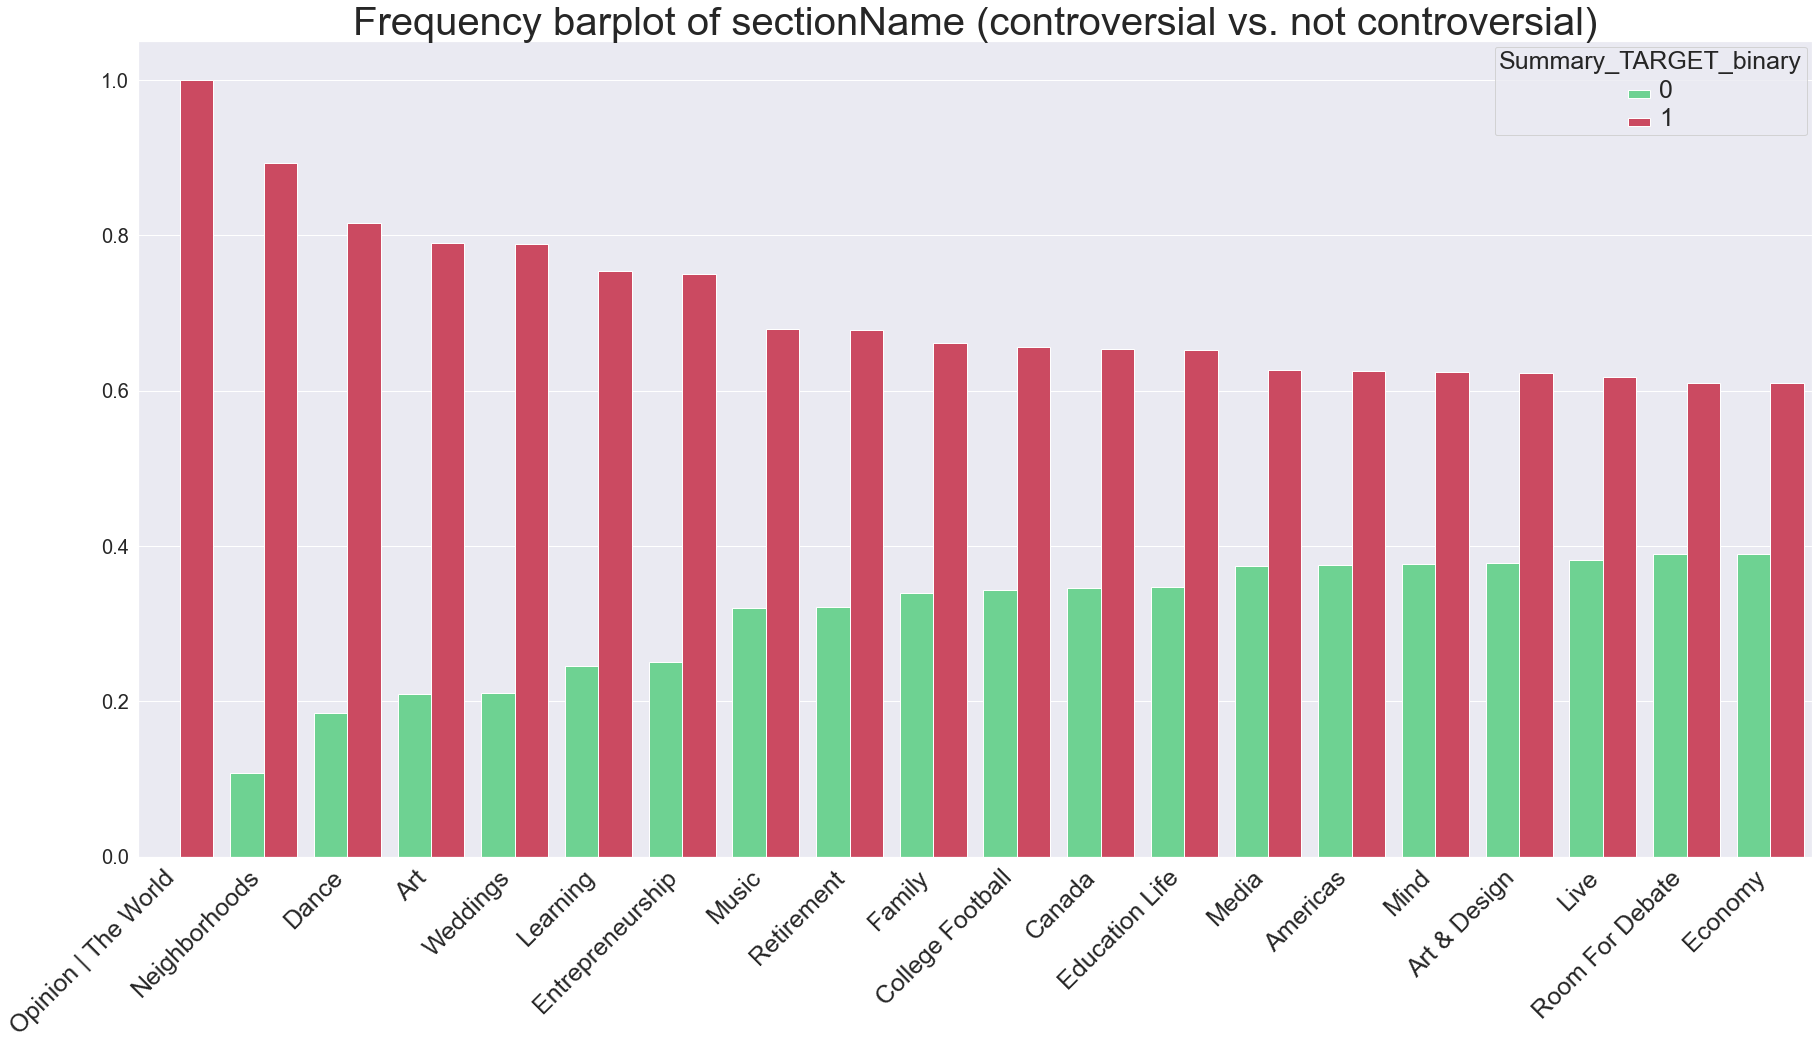

In [148]:
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(30,15)})
ax = sns.barplot(x='sectionName_x',y='count',hue='Summary_TARGET_binary', data=freq_sectionName_X, 
                 palette=["#5de38d", "#e03453"], order=ascending_freq_sectionName)
ax.set_title('Frequency barplot of sectionName (controversial vs. not controversial)',fontsize=40)

ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=25,rotation=45, horizontalalignment='right')
plt.setp(ax.get_legend().get_texts(), fontsize='25')
plt.setp(ax.get_legend().get_title(),fontsize=25)
ax.tick_params(axis="y", labelsize=20)

Now we do the same by using the different levels of controversy, in order to see how the classes are distributed over the controversial comments

In [185]:
freq_newDesk_X = pd.DataFrame(X.groupby(['newDesk_x','Summary_TARGET_multiclass']).count().iloc[:,0])
freq_newDesk_X.columns = ['count']

freq_newDesk_X = freq_newDesk_X / freq_newDesk_X.groupby('newDesk_x').sum()
freq_newDesk_X.reset_index(level=[0,1], inplace=True)

In [186]:
freq_newDesk_X

,newDesk_x,Summary_TARGET_multiclass,count
0,Arts&Leisure,0,0.378449
1,Arts&Leisure,1,0.465701
2,Arts&Leisure,2,0.145984
3,Arts&Leisure,3,0.009866
4,Automobiles,0,1.000000
...,...,...,...
160,Weekend,3,0.003611
161,Well,0,0.378799
162,Well,1,0.431722
163,Well,2,0.189064


In [200]:
freq_sectionName_X.columns

Index(['count'], dtype='object')

In [201]:
freq_sectionName_X = pd.DataFrame(X.groupby(['sectionName_x','Summary_TARGET_multiclass']).count().iloc[:,0])
freq_sectionName_X.columns = ['count']

freq_sectionName_X = freq_sectionName_X / freq_sectionName_X.groupby('sectionName_x').sum()
freq_sectionName_X.reset_index(level=[0,1], inplace=True)
freq_sectionName_X.loc[-1] = ['Opinion | The World', 0, 0.0]

In [202]:
freq_sectionName_X

,sectionName_x,Summary_TARGET_multiclass,count
0,401(k)'s and Similar Plans,0,0.494624
1,401(k)'s and Similar Plans,1,0.311828
2,401(k)'s and Similar Plans,2,0.182796
3,401(k)'s and Similar Plans,3,0.010753
4,Africa,0,0.411280
...,...,...,...
211,"Wine, Beer & Cocktails",0,0.580908
212,"Wine, Beer & Cocktails",1,0.311991
213,"Wine, Beer & Cocktails",2,0.105937
214,"Wine, Beer & Cocktails",3,0.001164


As before we discard all the topics having more than 40% of non-controversial comments

In [179]:
controversial_topics = freq_newDesk_X['newDesk_x'][(freq_newDesk_X['Summary_TARGET_multiclass']==0) & (freq_newDesk_X['count']<0.4)]
freq_newDesk_X = freq_newDesk_X[freq_newDesk_X['newDesk_x'].isin(list(controversial_topics))]

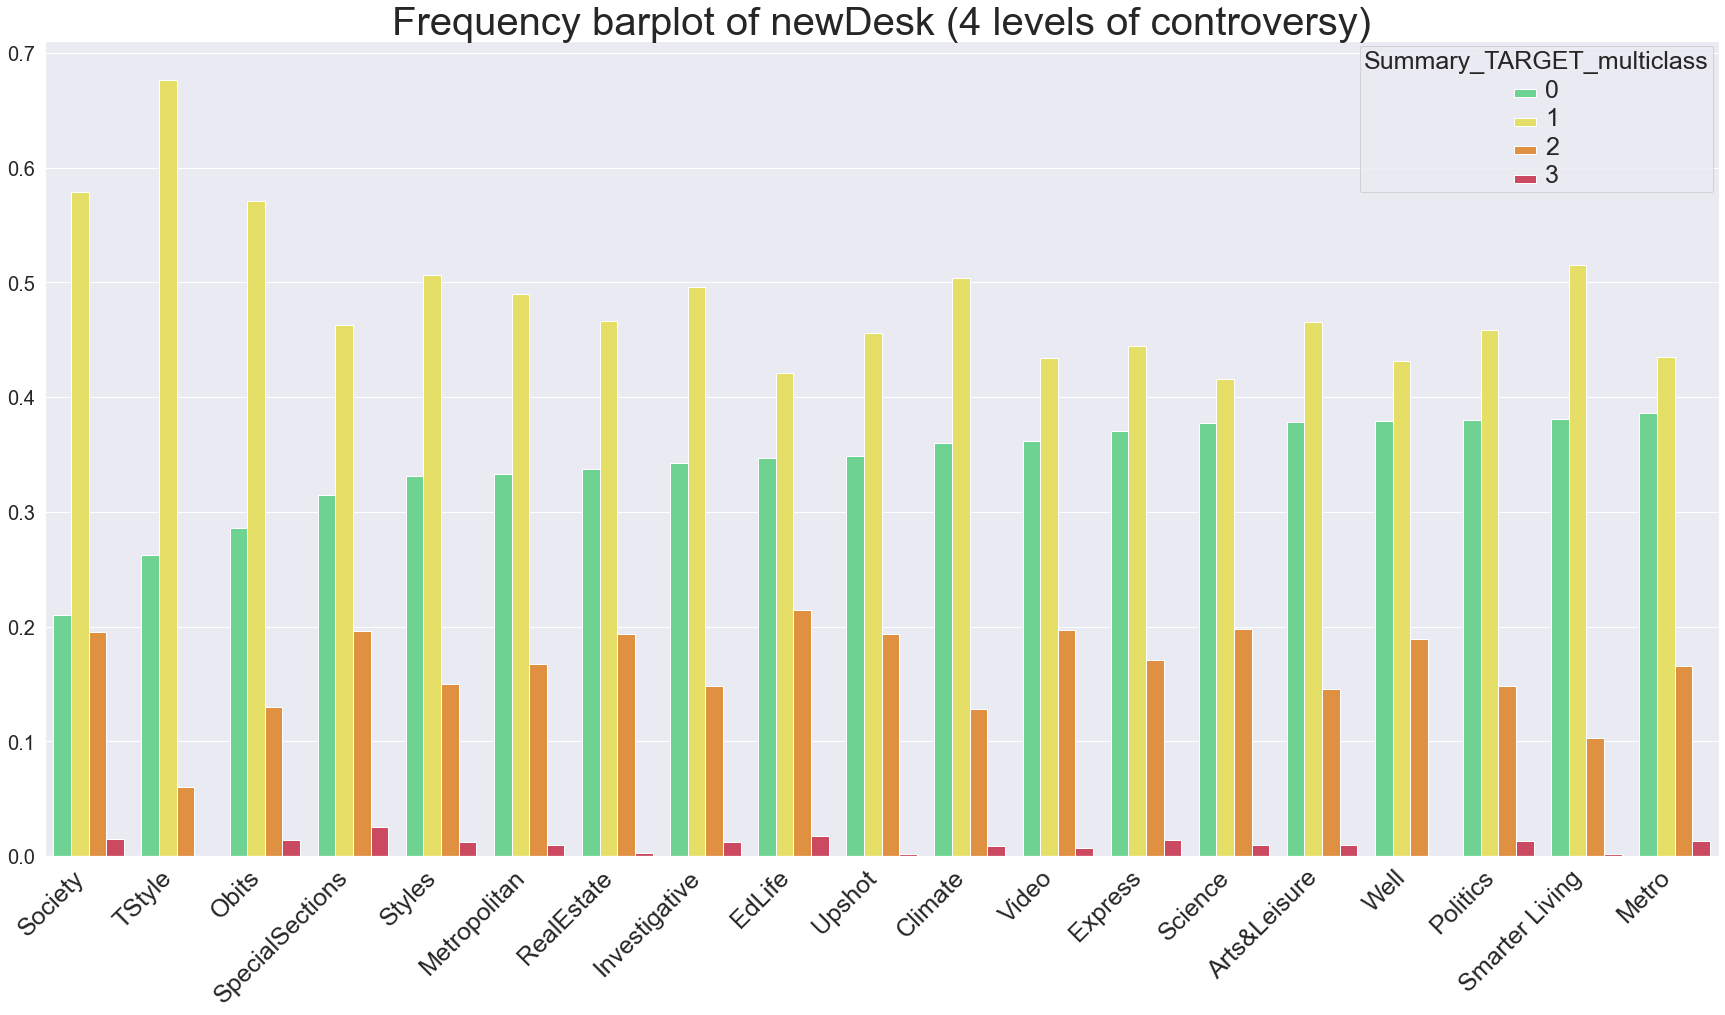

In [180]:
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(30,15)})
ax = sns.barplot(x='newDesk_x',y='count',hue='Summary_TARGET_multiclass', data=freq_newDesk_X, 
                 palette=["#5de38d", "#faf252", "#fa9025","#e03453"], order=ascending_freq_newDesk)
ax.set_title('Frequency barplot of newDesk (4 levels of controversy)',fontsize=40)

ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=25,rotation=45, horizontalalignment='right')
plt.setp(ax.get_legend().get_texts(), fontsize='25')
plt.setp(ax.get_legend().get_title(),fontsize=25)
ax.tick_params(axis="y", labelsize=20)

In [203]:
controversial_topics = freq_sectionName_X['sectionName_x'][(freq_sectionName_X ['Summary_TARGET_multiclass']==0) & (freq_sectionName_X ['count']<0.4)]
freq_sectionName_X  = freq_sectionName_X[freq_sectionName_X['sectionName_x'].isin(list(controversial_topics))]

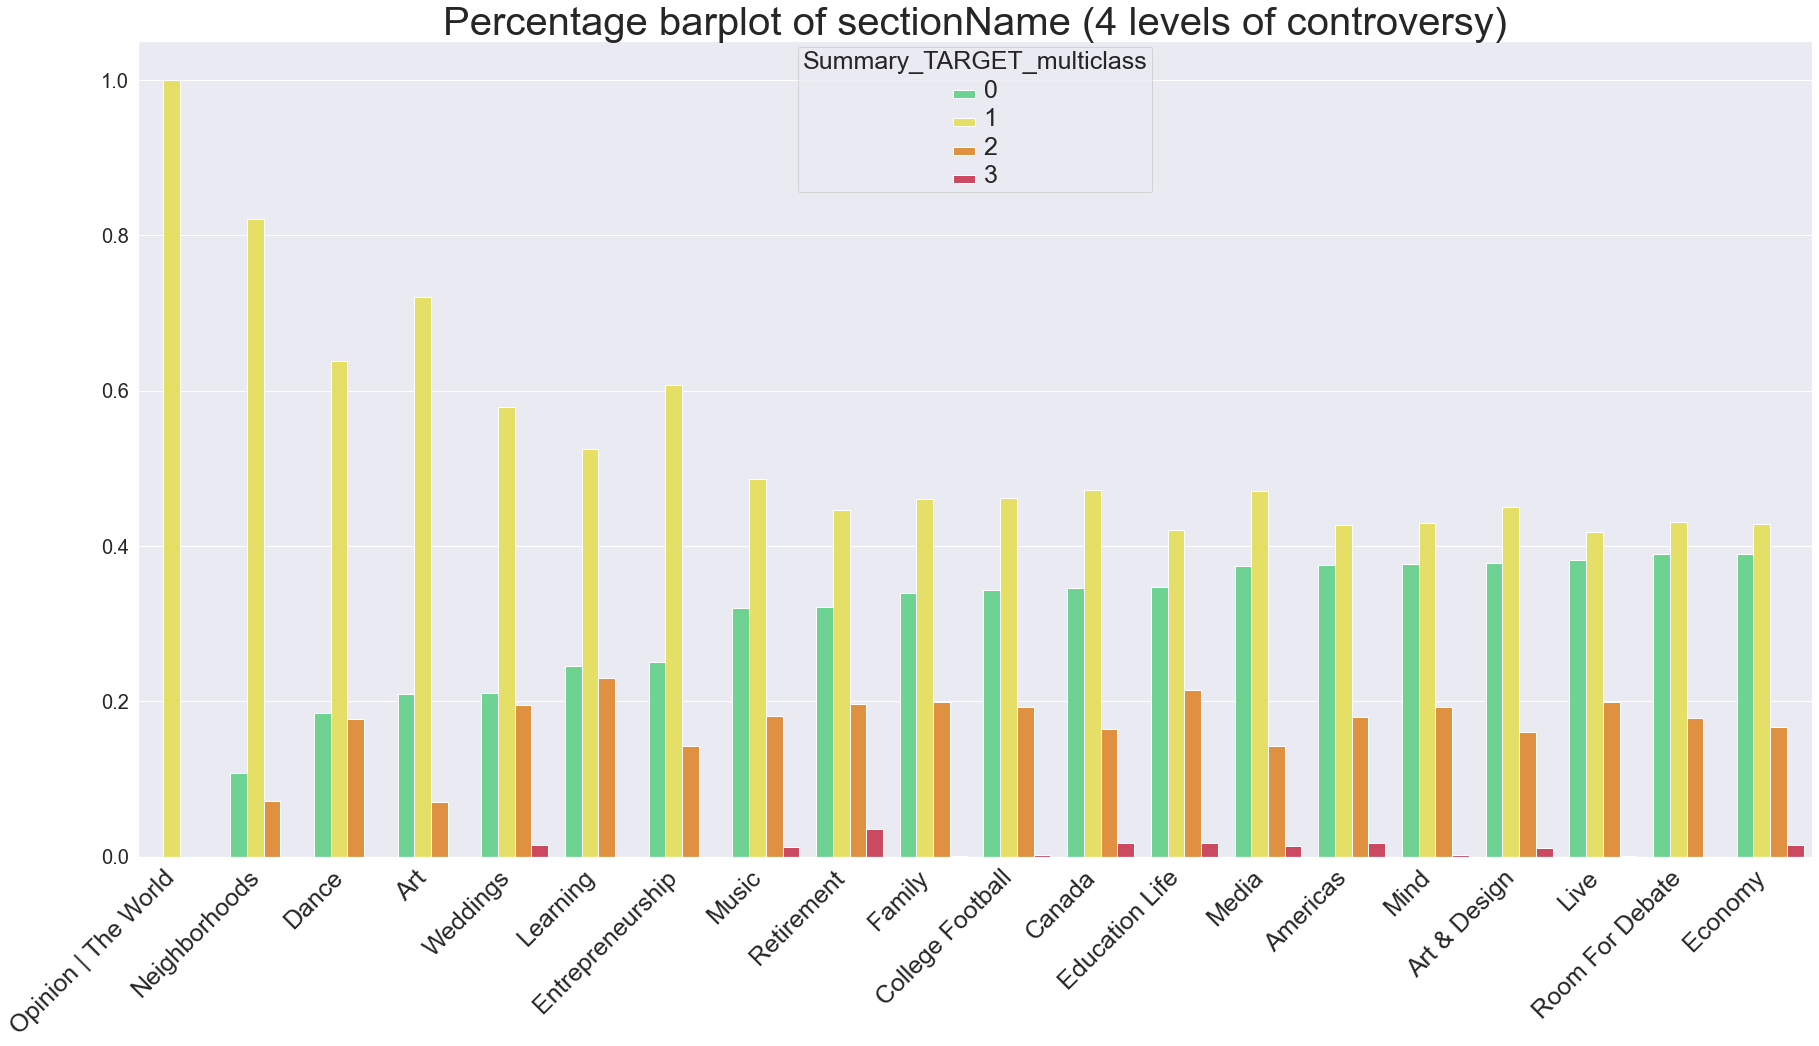

In [209]:
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(30,15)})
ax = sns.barplot(x='sectionName_x',y='count',hue='Summary_TARGET_multiclass', data=freq_sectionName_X, 
                 palette=["#5de38d", "#faf252", "#fa9025","#e03453"], order=ascending_freq_sectionName)
ax.set_title('Percentage barplot of sectionName (4 levels of controversy)',fontsize=40)

ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=25,rotation=45, horizontalalignment='right')
plt.setp(ax.get_legend().get_texts(), fontsize='25')
plt.setp(ax.get_legend().get_title(),fontsize=25)
ax.tick_params(axis="y", labelsize=20)